Cau 1 

Segmented image saved as 'lang_biang.jpg'


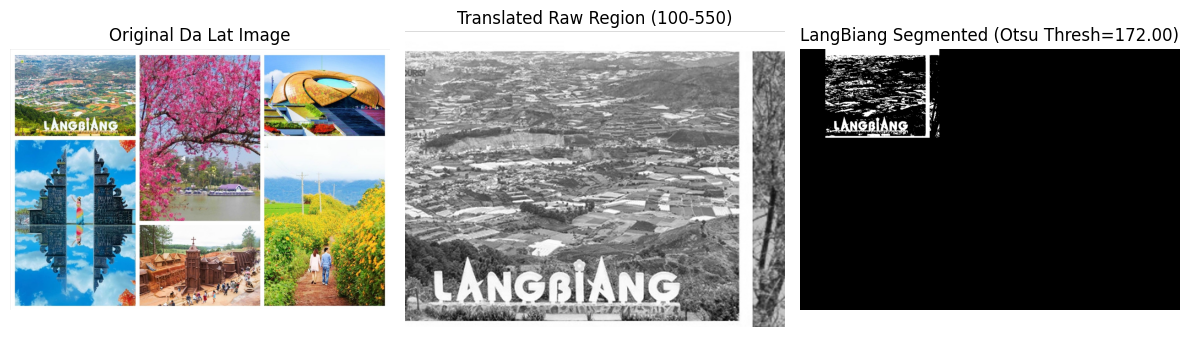

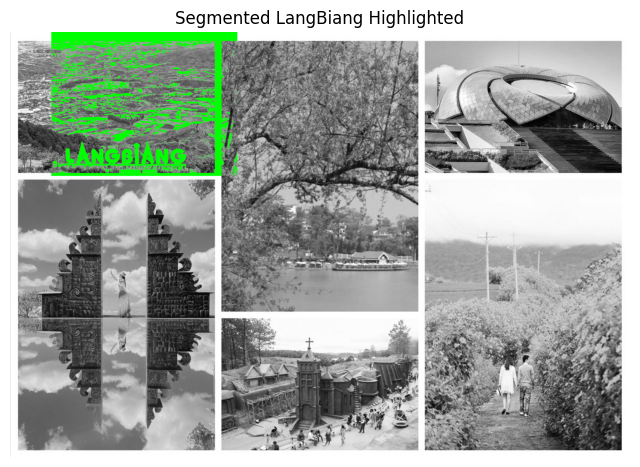

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu
import os

# --- 1. Load the image ---
# Assuming the image 'dalat.jpg' is in a folder named 'exercise'
# You might need to adjust the path if your setup is different.
image_path = os.path.join('exercise', 'dalat.jpg') 

# Check if the image file exists
if not os.path.exists(image_path):
    print(f"Error: Image file not found at {image_path}")
    print("Please make sure 'dalat.jpg' is in the 'exercise' folder.")
    exit()

img_bgr = cv2.imread(image_path)

if img_bgr is None:
    print(f"Error: Could not open or find the image at {image_path}")
    exit()

img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

# --- 2. Select the LangBiang region (Manual Selection - YOU NEED TO ADJUST THESE VALUES) ---
# These are example coordinates. You need to determine the actual coordinates
# of the LangBiang region in your 'dalat.jpg' image.
# You can use image editing software to get approximate pixel coordinates,
# or use a tool like matplotlib to display the image and click to get coords.
# Example: y_start, y_end, x_start, x_end
y1_original, y2_original = 0, 350  # Row/Y coordinates (top to bottom)
x1_original, x2_original = 0, 450  # Column/X coordinates (left to right)

# Ensure the selected region is within image bounds
img_height, img_width = img_gray.shape
y1_original = max(0, y1_original)
y2_original = min(img_height, y2_original)
x1_original = max(0, x1_original)
x2_original = min(img_width, x2_original)

langbiang_region_original = img_gray[y1_original:y2_original, x1_original:x2_original]

if langbiang_region_original.size == 0:
    print("Error: The selected LangBiang region is empty. Please check your coordinates.")
    exit()

# --- 3. Translate the selected region 100px to the right ---
translation_x = 100

# Calculate new coordinates for the translated region
x1_translated = x1_original + translation_x
x2_translated = x2_original + translation_x

# Ensure translated region is within image bounds
if x2_translated > img_width:
    print("Warning: Translated region goes out of image bounds on the right.")
    # Adjust the translation or the region if necessary, for this example we'll clip
    x2_translated = img_width
    x1_translated = x2_translated - (x2_original - x1_original)
    if x1_translated < 0: # If it still goes out of bounds on the left after clipping
        x1_translated = 0
        x2_translated = (x2_original - x1_original) # Keep the original width

# Create a blank image to place the translated region, or work directly on a copy of the original
# For simplicity, we'll extract the corresponding area from the original image based on new coordinates.
# This assumes we are selecting a *new* region 100px to the right, not moving the *content*.
# If you intended to *shift* the content of the *original* LangBiang region, it's more complex
# involving creating a new blank image and pasting.
# For now, let's assume we are selecting a new region *offset* by 100px.

# Extract the new region at the translated position
translated_region_raw = img_gray[y1_original:y2_original, x1_translated:x2_translated]

if translated_region_raw.size == 0:
    print("Error: The translated region is empty. Check original coordinates and translation.")
    exit()

# --- 4. Apply Otsu's thresholding on the translated region ---
# Otsu's method finds an optimal threshold automatically.
# The "ngưỡng 0.3" part is a bit ambiguous with Otsu.
# If it means to apply a *manual* threshold of 0.3 *after* Otsu, it doesn't make sense
# for binary images (pixel values 0 or 255).
# If it means to use 0.3 as a *factor* with the Otsu threshold, it's also unusual.
# I will interpret "phân vùng LangBiang theo ngưỡng 0.3" as applying Otsu, and then
# if a specific post-processing based on 0.3 (e.g., as a relative intensity) is needed,
# it would require clarification.
# For now, let's perform Otsu and then apply a threshold comparison with 0.3 *if* the image was normalized to 0-1.
# Since it's grayscale (0-255), 0.3 doesn't directly apply as a pixel value.
# I will assume the instruction meant to use Otsu for segmentation, and perhaps 0.3
# was a misunderstanding or a threshold for something else.
# Let's just do Otsu on the region. If 0.3 refers to the *ratio* of the threshold value, it's complex.

# For standard Otsu, it returns a single threshold value.
otsu_threshold = threshold_otsu(translated_region_raw)
binary_langbiang_region = translated_region_raw > otsu_threshold

# Create a copy of the original image to draw the results on
result_img_bgr = img_bgr.copy()
result_img_gray_display = img_gray.copy()

# Overlay the binary region back onto the grayscale image for visualization
# Convert binary_langbiang_region (boolean) to uint8 (0 or 255)
binary_display = (binary_langbiang_region * 255).astype(np.uint8)

# Place the processed region back into the original image's dimensions
# This creates a new image where only the translated and thresholded region is visible.
final_segmented_image = np.zeros_like(img_gray)
final_segmented_image[y1_original:y2_original, x1_translated:x2_translated] = binary_display

# You can also overlay this on the color image for better visualization
# Create a mask from the binary result
mask = np.zeros_like(img_gray, dtype=np.uint8)
mask[y1_original:y2_original, x1_translated:x2_translated] = binary_display

# Use the mask to highlight the region in the original color image
# You might want to colorize it for better visibility
colored_segmentation = cv2.cvtColor(img_gray, cv2.COLOR_GRAY2BGR)
colored_segmentation[mask > 0] = [0, 255, 0] # Highlight segmented area in green

# --- 5. Save the image ---
output_filename = 'lang_biang.jpg'
cv2.imwrite(output_filename, final_segmented_image) # Saving the binary segmented part

print(f"Segmented image saved as '{output_filename}'")

# --- 6. Display the image ---
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.imshow(img_bgr[:,:,::-1]) # Display original BGR image
plt.title('Original Da Lat Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(translated_region_raw, cmap='gray')
plt.title(f'Translated Raw Region ({x1_translated}-{x2_translated})')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(final_segmented_image, cmap='gray')
plt.title(f'LangBiang Segmented (Otsu Thresh={otsu_threshold:.2f})')
plt.axis('off')

plt.tight_layout()
plt.show()

# Display the segmented area highlighted on the original image
plt.figure(figsize=(8, 8))
plt.imshow(colored_segmentation[:,:,::-1]) # Convert BGR to RGB for matplotlib
plt.title('Segmented LangBiang Highlighted')
plt.axis('off')
plt.show()

Bai 2

Ảnh kết quả được lưu tại: 'ho_xuan_huong.jpg'


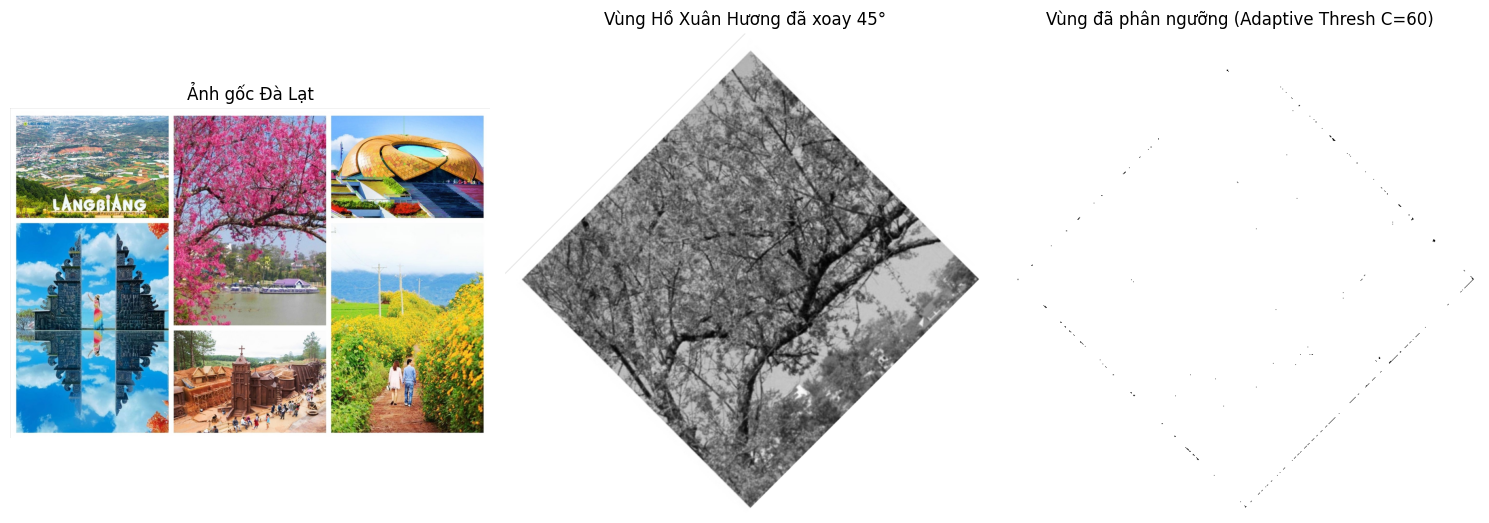

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# --- Cài đặt đường dẫn ảnh và tọa độ vùng Hồ Xuân Hương ---
image_path = os.path.join('exercise', 'dalat.jpg')

# Tọa độ vùng Hồ Xuân Hương ban đầu (y_start, y_end, x_start, x_end)
# BẠN CẦN ĐIỀU CHỈNH CÁC GIÁ TRỊ NÀY CHO PHÙ HỢP VỚI ẢNH CỦA BẠN
y1_original, y2_original = 0, 500  # Ví dụ: từ hàng 250 đến 550
x1_original, x2_original = 500, 1000  # Ví dụ: từ cột 150 đến 600

# --- 1. Đọc và chuyển đổi ảnh sang grayscale ---
img_bgr = cv2.imread(image_path)

if img_bgr is None:
    print(f"Lỗi: Không thể mở hoặc tìm thấy ảnh tại {image_path}")
    print("Vui lòng đảm bảo 'dalat.jpg' nằm trong thư mục 'exercise'.")
    exit()

img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

# Đảm bảo vùng chọn nằm trong giới hạn ảnh
img_height, img_width = img_gray.shape
y1_original = max(0, y1_original)
y2_original = min(img_height, y2_original)
x1_original = max(0, x1_original)
x2_original = min(img_width, x2_original)

# --- 2. Chọn vùng Hồ Xuân Hương ---
ho_xuan_huong_region = img_gray[y1_original:y2_original, x1_original:x2_original].copy()

if ho_xuan_huong_region.size == 0:
    print("Lỗi: Vùng Hồ Xuân Hương được chọn rỗng. Vui lòng kiểm tra lại tọa độ.")
    exit()

# --- 3. Xoay đối tượng vừa chọn một góc 45° ---
(h, w) = ho_xuan_huong_region.shape
center = (w // 2, h // 2)
angle = 45 # Góc xoay 45 độ

# Lấy ma trận xoay
M = cv2.getRotationMatrix2D(center, angle, 1.0)

# Tính toán kích thước mới của ảnh sau khi xoay để tránh cắt xén
cos = np.abs(M[0, 0])
sin = np.abs(M[0, 1])
nW = int((h * sin) + (w * cos))
nH = int((h * cos) + (w * sin))

# Điều chỉnh ma trận xoay để dịch chuyển tâm
M[0, 2] += (nW / 2) - center[0]
M[1, 2] += (nH / 2) - center[1]

rotated_region = cv2.warpAffine(ho_xuan_huong_region, M, (nW, nH), borderValue=255) # borderValue=255 để làm nền trắng

# --- 4. Dùng phương pháp Adaptive Thresholding với ngưỡng 60 ---
# Block size phải là số lẻ và lớn hơn 1
block_size = 11 # Kích thước vùng lân cận, ví dụ 11x11 pixel
C_value = 60    # Ngưỡng hằng số trừ đi từ giá trị trung bình/trọng số

# Áp dụng Adaptive Thresholding
# cv2.ADAPTIVE_THRESH_GAUSSIAN_C: Giá trị ngưỡng là tổng trọng số Gaussian của các giá trị lân cận trừ đi C.
# cv2.ADAPTIVE_THRESH_MEAN_C: Giá trị ngưỡng là giá trị trung bình của các giá trị lân cận trừ đi C.
# Ở đây ta dùng ADAPTIVE_THRESH_GAUSSIAN_C cho kết quả tốt hơn với ảnh tự nhiên.
thresh_region = cv2.adaptiveThreshold(rotated_region, 255,
                                      cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                      cv2.THRESH_BINARY, block_size, C_value)

# --- 5. Lưu vào máy với tên ho_xuan_huong.jpg ---
output_filename = 'ho_xuan_huong.jpg'
cv2.imwrite(output_filename, thresh_region)
print(f"Ảnh kết quả được lưu tại: '{output_filename}'")

# --- 6. Hiển thị ảnh trên màn hình ---
plt.figure(figsize=(15, 6))

plt.subplot(1, 3, 1)
plt.imshow(img_bgr[:, :, ::-1]) # Hiển thị ảnh gốc (chuyển BGR sang RGB cho matplotlib)
plt.title('Ảnh gốc Đà Lạt')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(rotated_region, cmap='gray')
plt.title('Vùng Hồ Xuân Hương đã xoay 45°')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(thresh_region, cmap='gray')
plt.title(f'Vùng đã phân ngưỡng (Adaptive Thresh C={C_value})')
plt.axis('off')

plt.tight_layout()
plt.show()

Bai 3

Ảnh kết quả được lưu tại: 'quan_truong_lam_vien.jpg'


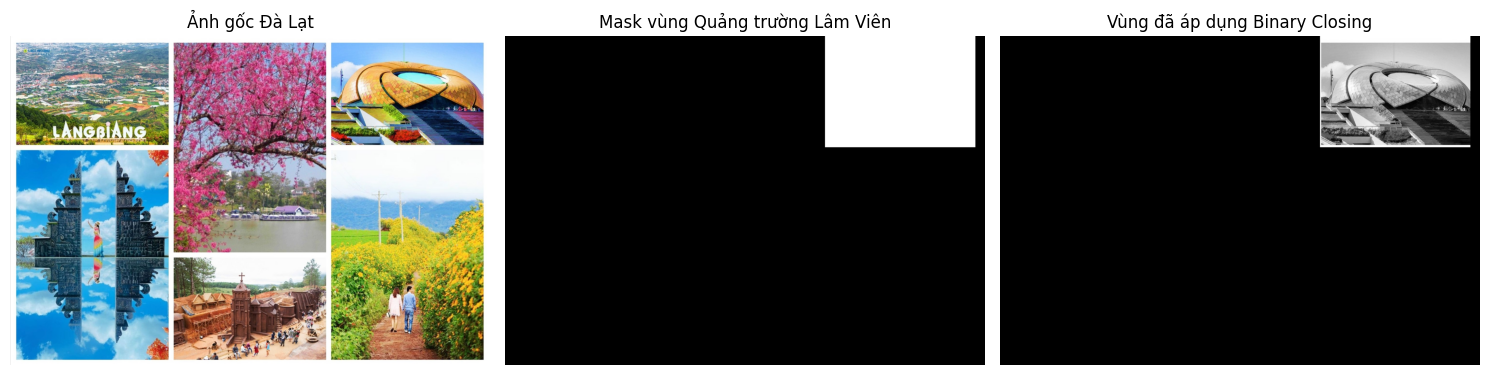

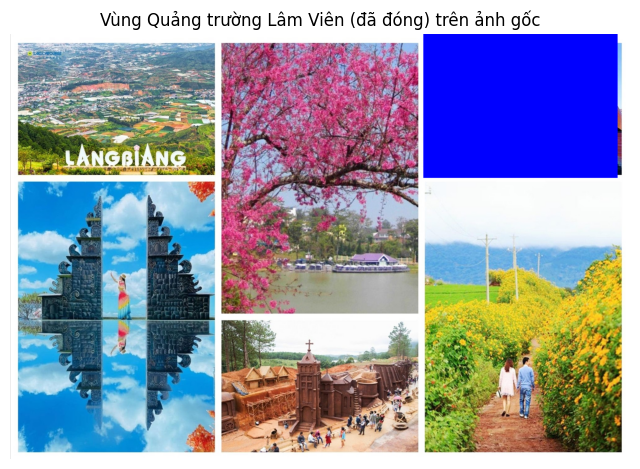

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.ndimage import binary_closing

# --- Cài đặt đường dẫn ảnh và tọa độ vùng Quảng trường Lâm Viên ---
image_path = os.path.join('exercise', 'dalat.jpg')

# Tọa độ vùng Quảng trường Lâm Viên ban đầu (y_start, y_end, x_start, x_end)
# BẠN CẦN ĐIỀU CHỈNH CÁC GIÁ TRỊ NÀY CHO PHÙ HỢP VỚI ẢNH CỦA BẠN
y1, y2 = 0, 350  # Ví dụ: từ hàng 350 đến 650
x1, x2 = 1000, 1470  # Ví dụ: từ cột 300 đến 700

# --- 1. Đọc ảnh và chuyển đổi sang grayscale ---
img_bgr = cv2.imread(image_path)

if img_bgr is None:
    print(f"Lỗi: Không thể mở hoặc tìm thấy ảnh tại {image_path}")
    print("Vui lòng đảm bảo 'dalat.jpg' nằm trong thư mục 'exercise'.")
    exit()

img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

# Đảm bảo vùng chọn nằm trong giới hạn ảnh
img_height, img_width = img_gray.shape
y1 = max(0, y1)
y2 = min(img_height, y2)
x1 = max(0, x1)
x2 = min(img_width, x2)

# --- 2. Chọn vùng Quảng trường Lâm Viên và áp dụng Coordinate Mapping (tạo mask) ---
# Tạo một mask nhị phân cho vùng chọn
mask = np.zeros_like(img_gray, dtype=np.uint8)
mask[y1:y2, x1:x2] = 255 # Đặt các pixel trong vùng chọn thành màu trắng (255)

# Áp dụng mask lên ảnh grayscale gốc để chỉ lấy vùng quan tâm
# Các pixel ngoài vùng mask sẽ là 0 (đen)
region_of_interest = cv2.bitwise_and(img_gray, img_gray, mask=mask)

# Để áp dụng binary closing, chúng ta cần một ảnh nhị phân (chỉ 0 và 1 hoặc 0 và 255).
# Giả sử chúng ta muốn áp dụng closing lên chính vùng đó,
# chúng ta có thể ngưỡng hóa nó trước nếu nó có nhiều sắc độ xám.
# Hoặc nếu mục đích là làm mịn biên của vùng đã chọn, chúng ta có thể làm việc trực tiếp trên mask.
# Tôi sẽ áp dụng binary closing trên vùng đã được tách ra từ ảnh gốc (region_of_interest)
# sau khi đã ngưỡng hóa nó.

# Thường thì Binary Closing hoạt động tốt nhất trên ảnh đã được nhị phân hóa.
# Ta sẽ nhị phân hóa vùng quan tâm này (ví dụ, bằng Otsu hoặc một ngưỡng cố định)
# để có thể áp dụng binary closing một cách hiệu quả.
# Nếu mục tiêu là làm mịn biên của MASK, thì làm trên mask trực tiếp sẽ hợp lý hơn.
# Với yêu cầu "Binary Closing cho vùng vừa chọn", tôi sẽ giả định là trên chính mask vùng chọn.

# Chuyển mask sang boolean cho scipy.ndimage
mask_boolean = mask > 0

# --- 3. Dùng phương pháp Binary Closing cho vùng vừa chọn ---
# Định nghĩa một structuring element (kernel)
# Kernel hình elip hoặc hình chữ nhật thường được dùng
# Example: kernel = np.ones((5,5),np.uint8) for a 5x5 square
# For scipy.ndimage, a simple square structuring element:
struct_element = np.ones((5,5), dtype=bool) # Ví dụ kernel 5x5
# Bạn có thể thử các kích thước kernel khác nhau hoặc hình dạng khác

closed_mask_boolean = binary_closing(mask_boolean, structure=struct_element, iterations=1)
closed_mask = (closed_mask_boolean * 255).astype(np.uint8)

# Áp dụng mask đã đóng lên ảnh grayscale gốc để lấy kết quả cuối cùng
final_image = cv2.bitwise_and(img_gray, img_gray, mask=closed_mask)


# Để minh họa rõ hơn, chúng ta có thể tạo một ảnh màu highlight
highlighted_img = img_bgr.copy()
# Tạo mask màu xanh cho vùng đã được xử lý
highlighted_img[closed_mask > 0] = [255, 0, 0] # Màu xanh dương (BGR) cho vùng đã đóng


# --- 4. Lưu vào máy với tên quan_truong_lam_vien.jpg ---
output_filename = 'quan_truong_lam_vien.jpg'
cv2.imwrite(output_filename, final_image) # Lưu ảnh grayscale đã đóng
print(f"Ảnh kết quả được lưu tại: '{output_filename}'")

# --- Hiển thị ảnh trên màn hình ---
plt.figure(figsize=(15, 6))

plt.subplot(1, 3, 1)
plt.imshow(img_bgr[:, :, ::-1]) # Ảnh gốc
plt.title('Ảnh gốc Đà Lạt')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(mask, cmap='gray') # Mask ban đầu
plt.title('Mask vùng Quảng trường Lâm Viên')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(final_image, cmap='gray') # Ảnh đã áp dụng Binary Closing
plt.title('Vùng đã áp dụng Binary Closing')
plt.axis('off')

plt.tight_layout()
plt.show()

# Hiển thị ảnh gốc với vùng đã xử lý được highlight
plt.figure(figsize=(8, 8))
plt.imshow(highlighted_img[:, :, ::-1])
plt.title('Vùng Quảng trường Lâm Viên (đã đóng) trên ảnh gốc')
plt.axis('off')
plt.show()

Bai 4


--- Menu Xử lý ảnh ---
geometric_transformation
  1. coordinate_mapping
  2. Rotate
  3. Scale
  4. Shift
segment
  5. Adaptive_thresholding
  6. Binary_dilation
  7. Binary_erosion
  8. Otsu
-------------------------
9. Kết hợp 2 chức năng (1 geometric_transformation + 1 segment)
0. Thoát
-------------------------


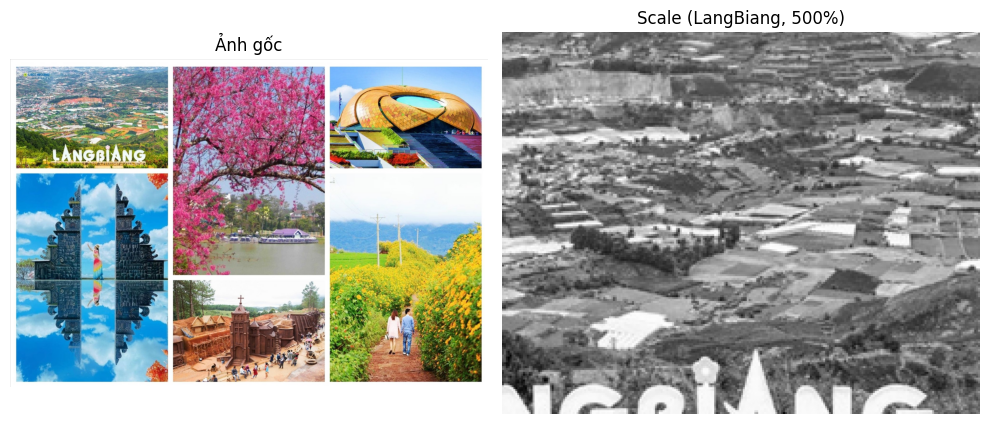


--- Menu Xử lý ảnh ---
geometric_transformation
  1. coordinate_mapping
  2. Rotate
  3. Scale
  4. Shift
segment
  5. Adaptive_thresholding
  6. Binary_dilation
  7. Binary_erosion
  8. Otsu
-------------------------
9. Kết hợp 2 chức năng (1 geometric_transformation + 1 segment)
0. Thoát
-------------------------
Thoát chương trình. Tạm biệt!


In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from skimage.filters import threshold_otsu
from scipy.ndimage import binary_dilation, binary_erosion # Used for dilation and erosion

# --- Configuration ---
IMAGE_PATH = os.path.join('exercise', 'dalat.jpg')

# Define regions (These are example coordinates, adjust as needed for your 'dalat.jpg')
# LangBiang coordinates (for Shift and Otsu)
LANG_BIANG_COORDS = {'y1': 100, 'y2': 300, 'x1': 200, 'x2': 450}
# Ho Xuan Huong coordinates (for Rotate and Adaptive Thresholding)
HO_XUAN_HUONG_COORDS = {'y1': 250, 'y2': 550, 'x1': 150, 'x2': 600}
# Quan Truong Lam Vien coordinates (for Coordinate Mapping and Binary operations)
QUAN_TRUONG_LAM_VIEN_COORDS = {'y1': 350, 'y2': 650, 'x1': 300, 'x2': 700}

# --- Helper Functions for Image Operations ---

def load_and_preprocess_image(path):
    """Loads an image and converts it to grayscale."""
    img_bgr = cv2.imread(path)
    if img_bgr is None:
        print(f"Lỗi: Không thể mở hoặc tìm thấy ảnh tại {path}")
        return None, None
    img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    return img_bgr, img_gray

def get_region_of_interest(img, coords):
    """Extracts a region of interest based on given coordinates."""
    y1, y2, x1, x2 = coords['y1'], coords['y2'], coords['x1'], coords['x2']
    img_height, img_width = img.shape
    y1 = max(0, y1)
    y2 = min(img_height, y2)
    x1 = max(0, x1)
    x2 = min(img_width, x2)
    return img[y1:y2, x1:x2].copy(), (y1, y2, x1, x2)

def coordinate_mapping(img_gray, coords):
    """Applies coordinate mapping to create a mask for a specific region."""
    y1, y2, x1, x2 = coords['y1'], coords['y2'], coords['x1'], coords['x2']
    
    mask = np.zeros_like(img_gray, dtype=np.uint8)
    mask[y1:y2, x1:x2] = 255
    
    # Return the mask. The actual image processing will be done on this mask or with it.
    return mask

def rotate_object(img_region, angle=45):
    """Rotates an image region by a given angle."""
    (h, w) = img_region.shape
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)

    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))

    M[0, 2] += (nW / 2) - center[0]
    M[1, 2] += (nH / 2) - center[1]

    rotated = cv2.warpAffine(img_region, M, (nW, nH), borderValue=255)
    return rotated

def scale_object(img_region, scale_factor=0.5):
    """Scales an image region by a given factor."""
    new_width = int(img_region.shape[1] * scale_factor)
    new_height = int(img_region.shape[0] * scale_factor)
    scaled = cv2.resize(img_region, (new_width, new_height), interpolation=cv2.INTER_AREA)
    return scaled

def shift_object(img_region, shift_x=100, shift_y=0):
    """Shifts an image region by a given offset."""
    # This function shifts the *content* of the region within a larger canvas
    # or creates a new image with shifted content.
    # For simplicity, let's create a new blank canvas and paste the region.
    h, w = img_region.shape
    shifted_canvas = np.zeros_like(img_region) # Or create a larger canvas if out of bounds
    
    # Calculate target coordinates for pasting
    target_x1 = max(0, shift_x)
    target_y1 = max(0, shift_y)
    
    # Calculate source coordinates for cropping if target goes out of bounds
    src_x1 = max(0, -shift_x)
    src_y1 = max(0, -shift_y)

    # Determine overlap dimensions
    overlap_w = min(w - src_x1, w - target_x1)
    overlap_h = min(h - src_y1, h - target_y1)

    if overlap_w > 0 and overlap_h > 0:
        shifted_canvas[target_y1:target_y1 + overlap_h, target_x1:target_x1 + overlap_w] = \
            img_region[src_y1:src_y1 + overlap_h, src_x1:src_x1 + overlap_w]
    
    return shifted_canvas


def adaptive_thresholding_segment(img_region, block_size=11, C_value=60):
    """Applies Adaptive Thresholding to an image region."""
    if img_region.dtype != np.uint8: # Adaptive thresholding requires uint8
        img_region = img_region.astype(np.uint8)
    
    # Ensure block_size is odd and greater than 1
    if block_size % 2 == 0:
        block_size += 1
    if block_size < 3: # min block size is 3
        block_size = 3

    thresh = cv2.adaptiveThreshold(img_region, 255,
                                   cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY, block_size, C_value)
    return thresh

def binary_dilation_segment(img_region, iterations=50):
    """Applies Binary Dilation to an image region. Works best on binary images."""
    # Ensure region is boolean for scipy.ndimage
    if img_region.dtype != bool:
        # Simple threshold to make it binary for dilation if it's not already
        _, img_binary = cv2.threshold(img_region, 127, 255, cv2.THRESH_BINARY)
        img_boolean = img_binary > 0
    else:
        img_boolean = img_region

    dilated = binary_dilation(img_boolean, iterations=iterations)
    return (dilated * 255).astype(np.uint8)

def binary_erosion_segment(img_region, iterations=50):
    """Applies Binary Erosion to an image region. Works best on binary images."""
    # Ensure region is boolean for scipy.ndimage
    if img_region.dtype != bool:
        # Simple threshold to make it binary for erosion if it's not already
        _, img_binary = cv2.threshold(img_region, 127, 255, cv2.THRESH_BINARY)
        img_boolean = img_binary > 0
    else:
        img_boolean = img_region

    eroded = binary_erosion(img_boolean, iterations=iterations)
    return (eroded * 255).astype(np.uint8)

def otsu_segment(img_region):
    """Applies Otsu's Thresholding to an image region."""
    if img_region.dtype != np.uint8: # Otsu requires uint8
        img_region = img_region.astype(np.uint8)
    
    try:
        thresh_val, thresh_img = cv2.threshold(img_region, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    except cv2.error as e:
        print(f"Lỗi khi áp dụng Otsu: {e}. Vùng ảnh có thể không đủ đa dạng pixel.")
        # Fallback to a simple binary threshold if Otsu fails
        thresh_val = 127
        _, thresh_img = cv2.threshold(img_region, thresh_val, 255, cv2.THRESH_BINARY)

    return thresh_img, thresh_val

# --- Main Program Logic ---

def display_menu():
    print("\n--- Menu Xử lý ảnh ---")
    print("geometric_transformation")
    print("  1. coordinate_mapping")
    print("  2. Rotate")
    print("  3. Scale")
    print("  4. Shift")
    print("segment")
    print("  5. Adaptive_thresholding")
    print("  6. Binary_dilation")
    print("  7. Binary_erosion")
    print("  8. Otsu")
    print("-------------------------")
    print("9. Kết hợp 2 chức năng (1 geometric_transformation + 1 segment)")
    print("0. Thoát")
    print("-------------------------")

def get_user_choice(prompt):
    while True:
        try:
            choice = input(prompt).strip()
            if choice.lower() == 'thoat' or choice == '0':
                return '0'
            return choice
        except ValueError:
            print("Lựa chọn không hợp lệ. Vui lòng nhập số.")

def process_single_function(choice, img_bgr, img_gray):
    result_img = None
    title = ""
    coords = None # To store coordinates of the region chosen

    if choice == '1': # coordinate_mapping
        coords = QUAN_TRUONG_LAM_VIEN_COORDS
        region, _ = get_region_of_interest(img_gray, coords)
        mask = coordinate_mapping(img_gray, coords)
        # For display, show the masked original region
        result_img = cv2.bitwise_and(img_gray, img_gray, mask=mask)
        title = "Coordinate Mapping (Quảng trường Lâm Viên)"

    elif choice == '2': # Rotate
        coords = HO_XUAN_HUONG_COORDS
        region, _ = get_region_of_interest(img_gray, coords)
        result_img = rotate_object(region)
        title = "Rotate (Hồ Xuân Hương, 45°)"

    elif choice == '3': # Scale
        coords = LANG_BIANG_COORDS # Using LangBiang coords for scaling example
        region, _ = get_region_of_interest(img_gray, coords)
        scale_factor = float(input("Nhập hệ số co giãn (ví dụ: 0.5 để giảm 50%, 2 để tăng 200%): "))
        result_img = scale_object(region, scale_factor)
        title = f"Scale (LangBiang, {scale_factor*100:.0f}%)"

    elif choice == '4': # Shift
        coords = LANG_BIANG_COORDS
        region, (y1, y2, x1, x2) = get_region_of_interest(img_gray, coords)
        
        # Create a blank canvas to paste the shifted region onto for display
        # We'll use a canvas same size as original image to show shift in context
        shifted_canvas = np.zeros_like(img_gray, dtype=np.uint8)
        
        shift_x = 100 # Example shift to the right
        shift_y = 0   # No vertical shift
        
        # Calculate new position for the region
        new_x1 = x1 + shift_x
        new_y1 = y1 + shift_y
        new_x2 = x2 + shift_x
        new_y2 = y2 + shift_y

        # Clamp to image boundaries
        new_x1 = max(0, new_x1)
        new_y1 = max(0, new_y1)
        new_x2 = min(img_gray.shape[1], new_x2)
        new_y2 = min(img_gray.shape[0], new_y2)

        # Calculate region dimensions to avoid issues if shifted part is clipped
        current_width = x2 - x1
        current_height = y2 - y1

        # If the new region fits, paste it
        if new_x2 - new_x1 == current_width and new_y2 - new_y1 == current_height:
             shifted_canvas[new_y1:new_y2, new_x1:new_x2] = region
        else: # Handle clipping or incomplete shifts
             # This is a simplified approach. A more robust shift would involve
             # computing the overlapping part and copying only that.
             # For this menu, let's just re-extract the region at the new coords.
             # This means it's a "selection at a new shifted position", not "shifting the content of the original selection"
             result_img = img_gray[new_y1:new_y2, new_x1:new_x2]
             print(f"Lưu ý: Vùng dịch chuyển có thể bị cắt do giới hạn ảnh. Hiển thị vùng mới.")

        result_img = shifted_canvas if result_img is None else result_img # Use the canvas if not clipped
        title = f"Shift (LangBiang, +{shift_x}px ngang)"

    elif choice == '5': # Adaptive_thresholding
        coords = HO_XUAN_HUONG_COORDS
        region, _ = get_region_of_interest(img_gray, coords)
        result_img = adaptive_thresholding_segment(region, block_size=11, C_value=60)
        title = "Adaptive Thresholding (Hồ Xuân Hương, C=60)"

    elif choice == '6': # Binary_dilation
        coords = QUAN_TRUONG_LAM_VIEN_COORDS
        # For morphological ops, it's often better to work on a binary mask of the region
        mask = coordinate_mapping(img_gray, coords)
        # Apply a basic threshold to the region if it's grayscale, or just use the mask directly
        # Let's use the mask as the input for dilation/erosion
        result_img = binary_dilation_segment(mask, iterations=5) # Reduced iterations for visibility
        title = "Binary Dilation (Quảng trường Lâm Viên, 5 iter.)"
    
    elif choice == '7': # Binary_erosion
        coords = QUAN_TRUONG_LAM_VIEN_COORDS
        mask = coordinate_mapping(img_gray, coords)
        result_img = binary_erosion_segment(mask, iterations=5) # Reduced iterations for visibility
        title = "Binary Erosion (Quảng trường Lâm Viên, 5 iter.)"

    elif choice == '8': # Otsu
        coords = LANG_BIANG_COORDS
        region, _ = get_region_of_interest(img_gray, coords)
        result_img, _ = otsu_segment(region)
        title = "Otsu Thresholding (LangBiang)"

    if result_img is not None:
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(img_bgr[:, :, ::-1])
        plt.title('Ảnh gốc')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(result_img, cmap='gray')
        plt.title(title)
        plt.axis('off')
        plt.tight_layout()
        plt.show()
    else:
        print("Không có kết quả để hiển thị hoặc có lỗi xảy ra.")

def process_combined_functions(geo_choice, seg_choice, img_bgr, img_gray):
    intermediate_img = None
    intermediate_coords = None
    geo_title = ""
    seg_title = ""

    # --- Step 1: Geometric Transformation ---
    if geo_choice == '1': # coordinate_mapping
        intermediate_coords = QUAN_TRUONG_LAM_VIEN_COORDS
        intermediate_img = coordinate_mapping(img_gray, intermediate_coords) # This is a mask
        geo_title = "Coordinate Mapping"
    elif geo_choice == '2': # Rotate
        intermediate_coords = HO_XUAN_HUONG_COORDS
        region, _ = get_region_of_interest(img_gray, intermediate_coords)
        intermediate_img = rotate_object(region)
        geo_title = "Rotate (45°)"
    elif geo_choice == '3': # Scale
        intermediate_coords = LANG_BIANG_COORDS
        region, _ = get_region_of_interest(img_gray, intermediate_coords)
        scale_factor = 0.7 # Fixed scale factor for combined ops
        intermediate_img = scale_object(region, scale_factor)
        geo_title = f"Scale ({scale_factor*100:.0f}%)"
    elif geo_choice == '4': # Shift
        intermediate_coords = LANG_BIANG_COORDS
        region, (y1, y2, x1, x2) = get_region_of_interest(img_gray, intermediate_coords)
        shift_x = 50 # Fixed shift for combined ops
        shift_y = 50
        
        # Create a new canvas to show the shifted content
        shifted_canvas = np.zeros_like(img_gray, dtype=np.uint8)
        
        new_x1 = x1 + shift_x
        new_y1 = y1 + shift_y
        new_x2 = x2 + shift_x
        new_y2 = y2 + shift_y

        new_x1 = max(0, new_x1)
        new_y1 = max(0, new_y1)
        new_x2 = min(img_gray.shape[1], new_x2)
        new_y2 = min(img_gray.shape[0], new_y2)

        current_width = x2 - x1
        current_height = y2 - y1

        if new_x2 - new_x1 == current_width and new_y2 - new_y1 == current_height:
             shifted_canvas[new_y1:new_y2, new_x1:new_x2] = region
             intermediate_coords = {'y1':new_y1, 'y2':new_y2, 'x1':new_x1, 'x2':new_x2} # Update coords for next step
        else:
             intermediate_img = img_gray[new_y1:new_y2, new_x1:new_x2] # If clipped, work on the clipped part
             intermediate_coords = {'y1':0, 'y2':intermediate_img.shape[0], 'x1':0, 'x2':intermediate_img.shape[1]} # Coords relative to the new small image
             print("Lưu ý: Vùng dịch chuyển trong kết hợp có thể bị cắt.")

        intermediate_img = shifted_canvas if intermediate_img is None else intermediate_img
        geo_title = f"Shift (+{shift_x}x, +{shift_y}y)"
        
    if intermediate_img is None:
        print("Lỗi: Không thể thực hiện biến đổi hình học.")
        return

    # --- Step 2: Segmentation (on the result of geometric transformation) ---
    final_img = None
    if seg_choice == '5': # Adaptive_thresholding
        final_img = adaptive_thresholding_segment(intermediate_img, block_size=11, C_value=60)
        seg_title = "Adaptive Thresholding"
    elif seg_choice == '6': # Binary_dilation
        final_img = binary_dilation_segment(intermediate_img, iterations=3)
        seg_title = "Binary Dilation"
    elif seg_choice == '7': # Binary_erosion
        final_img = binary_erosion_segment(intermediate_img, iterations=3)
        seg_title = "Binary Erosion"
    elif seg_choice == '8': # Otsu
        final_img, _ = otsu_segment(intermediate_img)
        seg_title = "Otsu Thresholding"

    if final_img is not None:
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(img_bgr[:, :, ::-1])
        plt.title('Ảnh gốc')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(intermediate_img, cmap='gray')
        plt.title(f'Bước 1: {geo_title}')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(final_img, cmap='gray')
        plt.title(f'Bước 2: {seg_title}')
        plt.axis('off')
        plt.tight_layout()
        plt.show()
    else:
        print("Lỗi: Không thể thực hiện phân đoạn sau biến đổi hình học.")


def main():
    if not os.path.exists(IMAGE_PATH):
        print(f"Lỗi: Không tìm thấy ảnh '{IMAGE_PATH}'. Vui lòng đảm bảo ảnh và thư mục 'exercise' tồn tại.")
        return

    img_bgr, img_gray = load_and_preprocess_image(IMAGE_PATH)
    if img_bgr is None:
        return

    while True:
        display_menu()
        choice = get_user_choice("Nhập lựa chọn của bạn (0-9): ")

        if choice == '0':
            print("Thoát chương trình. Tạm biệt!")
            break
        elif choice in ['1', '2', '3', '4', '5', '6', '7', '8']:
            process_single_function(choice, img_bgr, img_gray)
        elif choice == '9':
            print("\n--- Chọn chức năng kết hợp ---")
            geo_choice = get_user_choice("Chọn chức năng geometric_transformation (1-4): ")
            if geo_choice not in ['1', '2', '3', '4']:
                print("Lựa chọn biến đổi hình học không hợp lệ.")
                continue

            seg_choice = get_user_choice("Chọn chức năng segment (5-8): ")
            if seg_choice not in ['5', '6', '7', '8']:
                print("Lựa chọn phân đoạn không hợp lệ.")
                continue
            
            process_combined_functions(geo_choice, seg_choice, img_bgr, img_gray)
        else:
            print("Lựa chọn không hợp lệ. Vui lòng thử lại.")

if __name__ == "__main__":
    main()